# IMPORT LIBRARY

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# INISIAL PARAMETER

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
# Images are RGB
CHANNELS=3
EPOCHS=40

# LOAD DATASET

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/citrus-leaf-disease-image/Citrus Leaf Disease Image",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 607 files belonging to 5 classes.


In [4]:
class_names=dataset.class_names
class_names

['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']

# SPLIT DATASET

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[2 2 1 0 0 2 2 1 0 3 0 0 2 1 2 2]


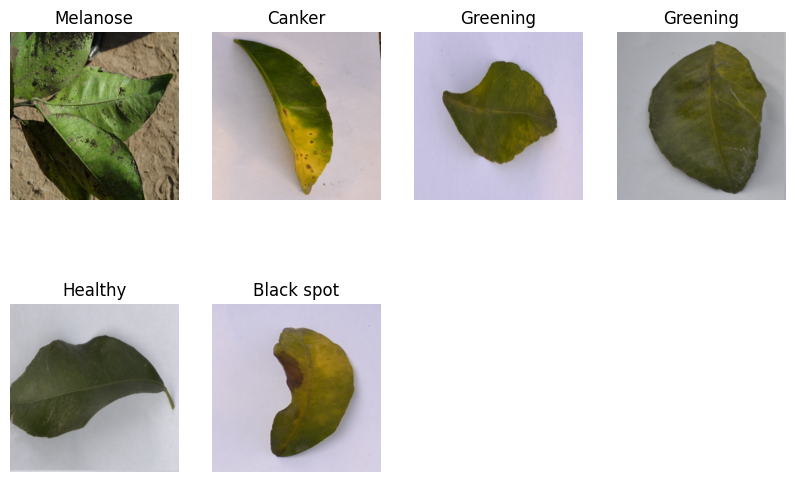

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

MENAMPILKAN 6 HASIL TRAINING PERTAMA

In [7]:
len(dataset)

# MENGHITUNG JUMLAH BATCH DALAM DATASET

38

In [8]:
# 80% = training
# 10% validation
# 10% test
train_size = 0.8
len(dataset)*train_size

30.400000000000002

In [9]:
16*40

640

In [10]:
train_ds = dataset.take(30)
len(train_ds)

30

In [11]:
test_ds = dataset.skip(30)
len(test_ds)

8

In [12]:
val_size=0.1
len(dataset)*val_size

3.8000000000000003

In [13]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [14]:
test_ds = test_ds.skip(3)
len(test_ds)

5

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

30

In [18]:
len(val_ds)

3

In [19]:
len(test_ds)

5

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# PREPROCESSING DAN AUGMENTASI

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN MODEL

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5


# Create the model
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),  # Add Batch Normalization
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),  # Add Batch Normalization
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),  # Add Batch Normalization
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Add Batch Normalization
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Add Batch Normalization
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Add Batch Normalization
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Add Dropout
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

# import keras
# from keras.models import Sequential
# from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense
# import keras.backend as K

# model = Sequential()
# n_classes = 5
# inputShape = (256, 256, 3)  # Update with your actual input shape
# chanDim = -1

# if K.image_data_format() == "channels_first":
#     inputShape = (3, 256, 256)  # Update with your actual input shape
#     chanDim = 1
# Model.add(Conv2D(32,(3,3),inputshape=,activation=‘relu′))
# Model.add(MaxPooling2D(pool_size=(2,2)))
# Model1.add(conv2D(32,(3,3),activation=‘relu′))
# Model.add(MaxPooling2D(poolsize=(2,2)))
# Model.add(Flattn())
# Model.add(Dense(units=128,activation=′softmax))

# model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(32, (3, 3), padding="same"))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(128))
# model.add(Dense(n_classes))
# model.add(Activation("softmax"))


In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 batch_normalization (BatchN  (16, 254, 254, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (16, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (16, 125, 125, 64)      

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# TRAINING MODEL

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)

Epoch 1/40
30/30 [==============================] - 13s 171ms/step - loss: 1.5223 - accuracy: 0.4948 - val_loss: 1.3817 - val_accuracy: 0.4792
Epoch 2/40
30/30 [==============================] - 4s 121ms/step - loss: 0.9373 - accuracy: 0.6514 - val_loss: 1.6868 - val_accuracy: 0.3750
Epoch 3/40
30/30 [==============================] - 4s 119ms/step - loss: 0.7450 - accuracy: 0.7161 - val_loss: 2.5527 - val_accuracy: 0.3542
Epoch 4/40
30/30 [==============================] - 4s 122ms/step - loss: 0.6559 - accuracy: 0.7349 - val_loss: 2.6256 - val_accuracy: 0.3542
Epoch 5/40
30/30 [==============================] - 3s 113ms/step - loss: 0.6127 - accuracy: 0.7620 - val_loss: 3.1813 - val_accuracy: 0.3542
Epoch 6/40
30/30 [==============================] - 4s 118ms/step - loss: 0.4578 - accuracy: 0.8225 - val_loss: 4.2599 - val_accuracy: 0.3542
Epoch 7/40
30/30 [==============================] - 4s 117ms/step - loss: 0.4539 - accuracy: 0.8225 - val_loss: 3.1519 - val_accuracy: 0.3542
Epoch

# EVALUASI

In [28]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 1s 10ms/step - loss: 2.4607 - accuracy: 0.6375


In [29]:
scores

[2.4606773853302, 0.637499988079071]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 30}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])


40

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.522336721420288,
 0.9373461008071899,
 0.7450303435325623,
 0.6558724045753479,
 0.612745463848114]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

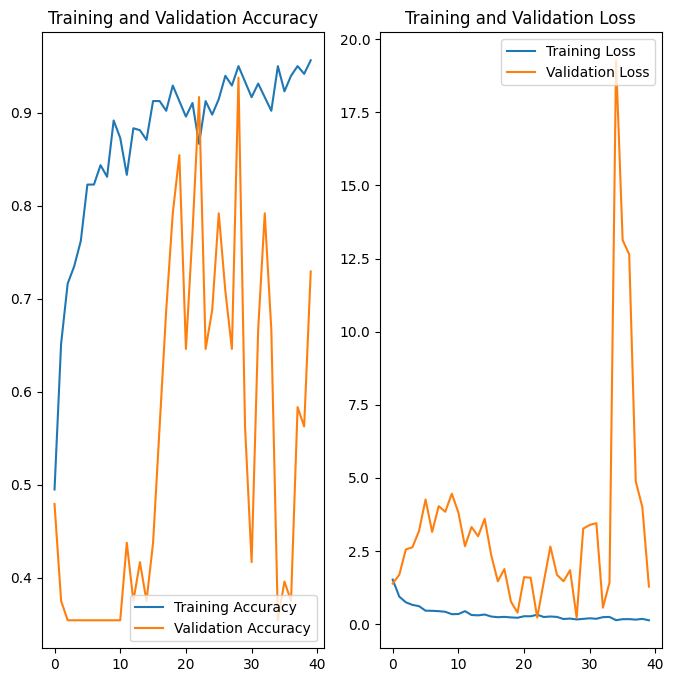

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Greening
1/1 [==============================] - 0s 177ms/step
predicted label: Greening


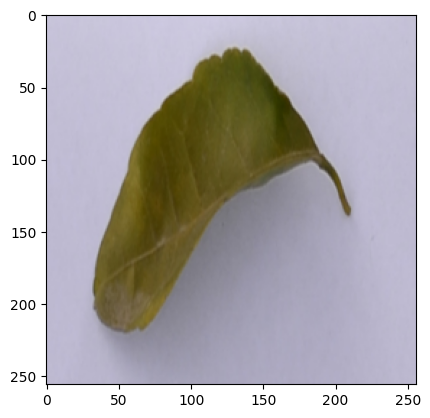

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


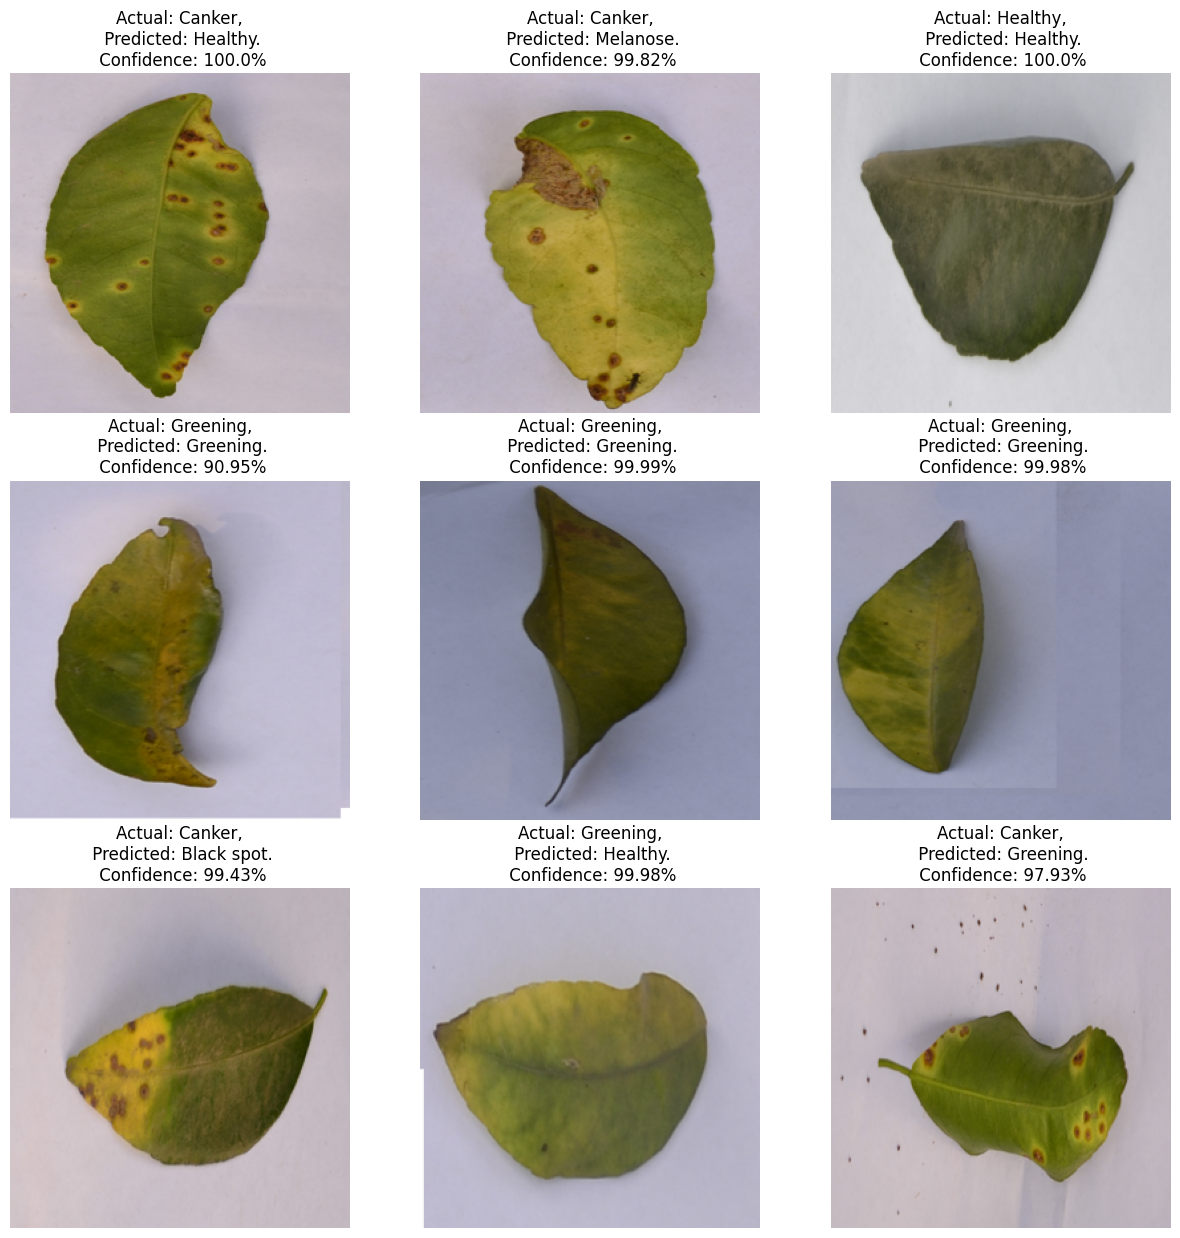

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [41]:
# import os
# model_version=max([int(i) for i in os.listdir("/kaggle/working/") + [0]])+1
# model.save(f"/kaggle/working/{model_version}")

In [42]:
# model.save("../citrus.h5")